In [10]:
using Turing
using DataFrames
using CSV
using Random
using StatisticalRethinking
using StatisticalRethinkingPlots
using StatsPlots
using StatsBase
using FreqTables

default(label=false)

# 11.1 Binomial regression

Code 11.1

In [5]:
d = DataFrame(CSV.File("data/chimpanzees.csv", delim=';'));

Code 11.2

In [6]:
d[!,:treatment] = 1 .+ d.prosoc_left .+ 2*d.condition;

Code 11.3

In [7]:
println(freqtable(d, :treatment, :prosoc_left, subset=d.condition .== 0))
println(freqtable(d, :treatment, :prosoc_left, subset=d.condition .== 1))

2×2 Named Matrix{Int64}
treatment ╲ prosoc_left │   0    1
────────────────────────┼─────────
1                       │ 126    0
2                       │   0  126
2×2 Named Matrix{Int64}
treatment ╲ prosoc_left │   0    1
────────────────────────┼─────────
3                       │ 126    0
4                       │   0  126


Code 11.4

In [8]:
@model function m11_1(pulled_left)
    a ~ Normal(0, 10)
    p = logistic(a)     # inverse of the `logit` function
    pulled_left ~ Binomial(1, p)
end

m11_1 (generic function with 2 methods)

Code 11.5

In [11]:
Random.seed!(1999)
prior_chain = sample(m11_1(d.pulled_left), Prior(), 10000)
prior = DataFrame(prior_chain);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Code 11.6

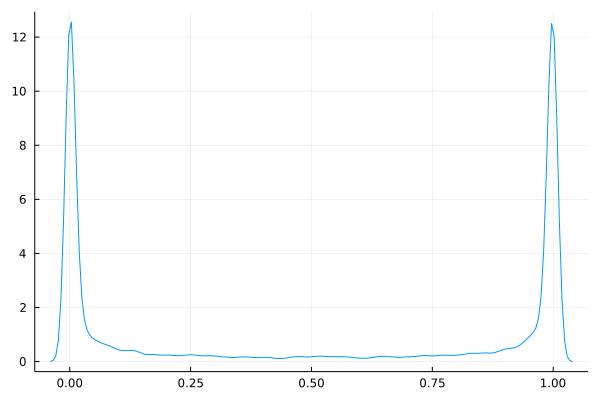

In [12]:
p = logistic.(prior.a)
density(p, bandwidth=0.01)

Code 11.7

In [13]:
@model function m11_2(pulled_left, treatment)
    a ~ Normal(0, 1.5)
    treat_levels = length(levels(d.treatment))
    b ~ MvNormal(zeros(treat_levels), 10)
    
    p = @. logistic(a + b[treatment])
    for i ∈ eachindex(pulled_left)
        pulled_left[i] ~ Binomial(1, p[i])
    end
end

Random.seed!(1999)
prior_chain = sample(m11_2(d.pulled_left, d.treatment), Prior(), 10000)
prior = DataFrame(prior_chain);

f = i -> @. logistic(prior.a + prior[!,"b[$i]"])
p = map(f, 1:4);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


Code 11.8

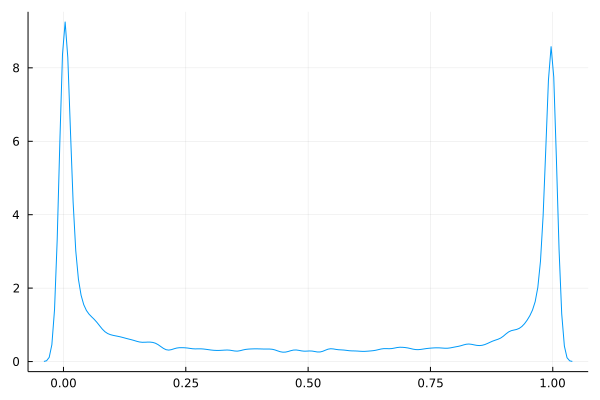

In [14]:
density(abs.(p[1] .- p[2]), bandwidth=0.01)

Code 11.9

In [15]:
@model function m11_3(pulled_left, treatment)
    a ~ Normal(0, 1.5)
    treat_levels = length(levels(d.treatment))
    b ~ MvNormal(zeros(treat_levels), 0.5)
    
    p = @. logistic(a + b[treatment])
    for i ∈ eachindex(pulled_left)
        pulled_left[i] ~ Binomial(1, p[i])
    end
end

Random.seed!(1999)
prior_chain = sample(m11_3(d.pulled_left, d.treatment), Prior(), 10000)
prior = DataFrame(prior_chain);

f = i -> @. logistic(prior.a + prior[!,"b[$i]"])
p = map(f, 1:4);

mean(abs.(p[1] .- p[2]))

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


0.09924607142428958

Code 11.10

In [16]:
dat_list = d[!,[:pulled_left, :actor, :treatment]];